In [ ]:
# when executed in a Google Colab setting, we must install the required libraries

# !pip install torch
# !pip install os
# !pip install transformers
# !pip install numpy
# !pip install pandas

In [ ]:
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.distributions.beta import Beta
from torch.nn.utils import weight_norm
import numpy as np
import pandas as pd
import random
import pickle
import time
import base64
from sklearn.metrics import average_precision_score, recall_score, classification_report, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import re

In [ ]:
#### Edit variables and filepaths here ####
DATASET_FILEPATH = './drive/MyDrive/Thesis/'
EMBEDDINGS = 'hubert_embeddings'
DATASET_SEED = 2
SEED = 42
torch.manual_seed(SEED)
SMALL_CAPACITY = False
EMB_SIZE = 'base' # 'base' 768 embeddings or 'large' 1024 embeddings
SAVE_WEIGHTS_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/tcn-base/model.pth')
SAVE_GRID_SEARCH_WEIGHTS_PATH = os.path.join(DATASET_FILEPATH, 'weights-and-graphs/grid-search-tcn/model.pth')

test_csv_file = os.path.join(DATASET_FILEPATH, f'{EMB_SIZE}/{DATASET_SEED}/processed/test_dataset.csv')

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device("cpu")
print('Device: ', device)

Device:  cpu


In [ ]:
def to_tensor(base64_str):
    return pickle.loads(base64.b64decode(base64_str.encode()))

selected_columns = ['audio_file_name', 'classification', EMBEDDINGS]
test_df = pd.read_csv(test_csv_file, usecols=selected_columns, converters={EMBEDDINGS: to_tensor})

In [ ]:
def print_dataset_balance(df):
    """
    Prints the balance of classifications in a given dataset.

    :param df: DataFrame containing the data with a 'classification' column.
    """
    classification_counts = df['classification'].value_counts().reset_index()
    classification_counts.columns = ['classification', 'count']
    total_rows = classification_counts['count'].sum()
    classification_counts['percentage'] = (classification_counts['count'] / total_rows) * 100
    classification_counts['percentage'] = classification_counts['percentage'].round(1)
    print(classification_counts)

In [ ]:
print_dataset_balance(test_df)

   classification  count  percentage
0               1    284        74.3
1               0     98        25.7


In [ ]:
class AudioEmbeddingsDataset(Dataset):
    def __init__(self, embeddings, file_names, labels):
        self.embeddings = embeddings
        self.file_names = file_names
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        file_name = self.file_names[idx]
        return label, file_name, embedding

# Creating DataLoader with custom collate function
FIXED_LENGTH = 250 # fixed sequence length that the model expects as an input

def collate_fn(batch):
    """
    Function to be passed to the DataLoader class which processes a batch of data points before being passed to the model in training.
    The TCN must process process data points of length 250, we adjust each data point in the batch to fit this requirement.

    :param batch: array of data points in the dataset.
    """

    labels, file_names, embeddings = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float32)

    # Truncate or zero-pad all sequences to a fixed length
    embeddings = [emb.squeeze(0) for emb in embeddings]
    embeddings = [emb[:FIXED_LENGTH, :] if emb.shape[0] > FIXED_LENGTH else torch.cat([emb, torch.zeros((FIXED_LENGTH - emb.shape[0], emb.shape[1]))]) for emb in embeddings]

    embeddings = torch.stack(embeddings)
    return embeddings, file_names, labels

audio_test_data = test_df[EMBEDDINGS]
test_labels = test_df['classification']
test_file_names = test_df['audio_file_name']

test_dataset = AudioEmbeddingsDataset(audio_test_data, test_file_names, test_labels)

In [ ]:
BATCH_SIZE = 1 # to allow for analysis of results

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [ ]:
class NormReLUChannelNormalization(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(NormReLUChannelNormalization, self).__init__()
        self.epsilon = epsilon
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(x)
        max_values, _ = torch.max(torch.abs(x), dim=2, keepdim=True)
        max_values += self.epsilon
        out = x / max_values
        return out

class WaveNetActivation(nn.Module):
    def __init__(self):
        super(WaveNetActivation, self).__init__()

    def forward(self, x):
        tanh_out = torch.tanh(x)
        sigm_out = torch.sigmoid(x)
        return tanh_out * sigm_out

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation, kernel_size, activation, dropout=0):
        super(ResidualBlock, self).__init__()
        chomp_size = (kernel_size-1) * dilation
        padding = (kernel_size-1) * dilation
        self.conv1 = weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size,
                                           stride=1, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(chomp_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.conv2 = weight_norm(nn.Conv1d(out_channels, out_channels, kernel_size,
                                           stride=1, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(chomp_size)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.activation, self.dropout,
                                 self.conv2, self.chomp2, self.activation, self.dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, dropout=0):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(out_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = in_channels if i == 0 else out_channels[i-1]
            activation = NormReLUChannelNormalization() if i%2 == 0 else WaveNetActivation()
            layers += [ResidualBlock(in_channels, out_channels[i], dilation=dilation_size,
                                     kernel_size=kernel_size, activation=activation, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class TCN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, dropout=0):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(in_channels, out_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(out_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        y1 = self.tcn(x)
        o = self.linear(y1[:, :, -1])
        return o


In [ ]:
GRID_SEARCH = False
model = TCN(768, [1024, 768, 384], kernel_size=2, dropout=0).to(device) # optimal

if not GRID_SEARCH:
  model.load_state_dict(torch.load(SAVE_WEIGHTS_PATH))
else:
  model.load_state_dict(torch.load(SAVE_GRID_SEARCH_WEIGHTS_PATH, map_location=torch.device('cpu')))
print('Loaded model in')
model.eval()  # set the model to evaluation mode

Loaded model in


TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(768, 1024, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (dropout): Dropout(p=0, inplace=False)
        (activation): NormReLUChannelNormalization(
          (relu): ReLU()
        )
        (conv2): Conv1d(1024, 1024, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (net): Sequential(
          (0): Conv1d(768, 1024, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): NormReLUChannelNormalization(
            (relu): ReLU()
          )
          (3): Dropout(p=0, inplace=False)
          (4): Conv1d(1024, 1024, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): NormReLUChannelNormalization(
            (relu): ReLU()
          )
          (7): Dropout(p=0, inplace=False)
        )
        (downsample): Conv1d(768, 1024, kernel_size=(1,), stride=(1

In [ ]:
TRUE_THRESHOLD = 0.5

y_name = []
y_true = []
y_score = []
y_assigned = []
latencies = []

def test(model, iterator):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for audio_embeddings, file_names, labels in iterator:
            start_time = time.time()
            output = model(audio_embeddings).squeeze(1)
            pred = torch.sigmoid(output)
            rounded_pred = torch.where(pred >= TRUE_THRESHOLD, torch.tensor(1, device=pred.device), torch.tensor(0, device=pred.device))
            end_time = time.time()

            latency = end_time - start_time
            latencies.append(latency)

            y_true.append(float(labels[0]))
            y_score.append(float(pred[0]))
            y_assigned.append(float(rounded_pred[0]))
            y_name.append(file_names[0])

test(model, test_loader)

In [ ]:
print(classification_report(y_true, y_assigned, target_names=['non-interruption', 'interruption']))

                  precision    recall  f1-score   support

non-interruption       0.49      0.63      0.55        98
    interruption       0.86      0.77      0.81       284

        accuracy                           0.74       382
       macro avg       0.67      0.70      0.68       382
    weighted avg       0.76      0.74      0.75       382



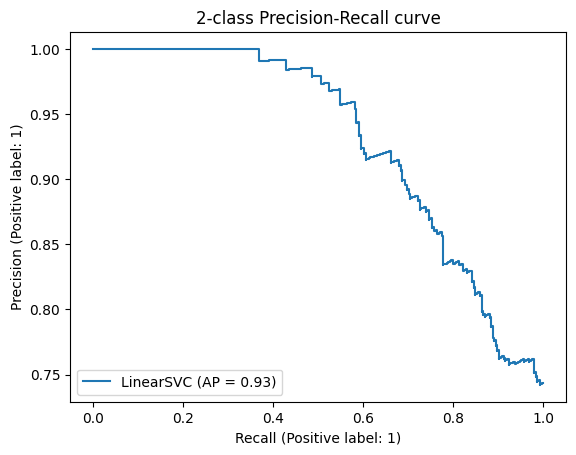

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    y_true, y_score, name="LinearSVC"
)

_ = display.ax_.set_title("2-class Precision-Recall curve") # how can we add label names
plt.show()

In [ ]:
mean_latency = (sum(latencies) / len(latencies)) * 1000
print(f"Mean Latency: {mean_latency:.3f} milliseconds")

Mean Latency: 111.140 milliseconds
